# Sign Language Image Classification with Vision Transformers

### American Sign Languange Dataset

### Download and unzip dataset

In [2]:
import os

# Set up dataset path and name
kaggle_dataset = "kapillondhe/american-sign-language"
dataset_dir = "./sign-language-dataset"  # Path to store the dataset

# Ensure the dataset directory exists
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
    print("Downloading dataset from Kaggle...")

    # Download and unzip the dataset
    os.system(f"kaggle datasets download -d {kaggle_dataset} -p {dataset_dir} --unzip")
    print("Dataset downloaded and unzipped.")
else:
    print("Dataset already downloaded.")


Dataset downloaded and unzipped.


In [ ]:
import os

dataset_dir = "./sign-language-dataset"

if os.path.exists(dataset_dir):
    print("Dataset directory exists.")
    print("Contents:", os.listdir(dataset_dir))
else:
    print("Dataset directory not found.")


Dataset directory exists.
Contents: ['ASL_Dataset']


In [ ]:
import os

dataset_path = "./sign-language-dataset/ASL_Dataset"
print("Contents of ASL_Dataset:", os.listdir(dataset_path))


Contents of ASL_Dataset: ['Test', 'Train']


### Import packages

In [6]:
# Import necessary libraries
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from timm import create_model
from tqdm import tqdm
import numpy as np


### CustomDataset Class

This class defines a custom dataset for loading images and labels, with an optional transformation applied to the images.


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset  # Directly store the dataset (no need for split)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Access the subset's data directly
        data = self.dataset[idx]
        image = data['image']
        label = data['label']

        if self.transform:
            image = self.transform(image)

        return image, label


## Load dataset

In [3]:
from datasets import load_dataset


# Specify the correct paths based on the Kaggle dataset directory
# dataset_dir = "./sign-language-dataset/ASL_Dataset"  # Path where the dataset is stored
train_dataset_path = f"{dataset_dir}/ASL_Dataset/Train"
test_dataset_path = f"{dataset_dir}/ASL_Dataset/Test"
# train_dataset_path = r"D:\Master\DNN\sign-language-image-detection\src\ViT\sign-datasets\sign_datasets\ASL_Dataset\Train"
# test_dataset_path = r"D:\Master\DNN\sign-language-image-detection\src\ViT\sign-datasets\sign_datasets\ASL_Dataset\Test"
# Load the train and test datasets separately using `imagefolder` format
train_dataset = load_dataset('imagefolder', data_dir=train_dataset_path)
test_dataset = load_dataset('imagefolder', data_dir=test_dataset_path)

# Print dataset details to verify
print("Train Dataset:", train_dataset)
print("Test Dataset:", test_dataset)


Resolving data files:   0%|          | 0/165670 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/112 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Train Dataset: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 165670
    })
})
Test Dataset: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 112
    })
})


In [ ]:
import os
import pickle
from datasets import load_dataset

# Specify dataset paths
train_dataset_path = r"D:\Master\DNN\sign-language-image-detection\src\ViT\sign-datasets\sign_datasets\ASL_Dataset\Train"
test_dataset_path = r"D:\Master\DNN\sign-language-image-detection\src\ViT\sign-datasets\sign_datasets\ASL_Dataset\Test"

# Cache filenames for train and test datasets
train_cache_file = "ASL_train_dataset_cache.pkl"
test_cache_file = "ASL_test_dataset_cache.pkl"

# Load train dataset from cache or source
if os.path.exists(train_cache_file):
    print("Loading train dataset from cache...")
    with open(train_cache_file, "rb") as f:
        train_dataset = pickle.load(f)
else:
    print("Loading train dataset from source and caching it...")
    train_dataset = load_dataset('imagefolder', data_dir=train_dataset_path)
    with open(train_cache_file, "wb") as f:
        pickle.dump(train_dataset, f)

# Load test dataset from cache or source
if os.path.exists(test_cache_file):
    print("Loading test dataset from cache...")
    with open(test_cache_file, "rb") as f:
        test_dataset = pickle.load(f)
else:
    print("Loading test dataset from source and caching it...")
    test_dataset = load_dataset('imagefolder', data_dir=test_dataset_path)
    with open(test_cache_file, "wb") as f:
        pickle.dump(test_dataset, f)

# Print dataset details to verify
print("Train Dataset:", train_dataset)
print("Test Dataset:", test_dataset)

Loading train dataset from source and caching it...
Loading test dataset from source and caching it...
Train Dataset: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 165670
    })
})
Test Dataset: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 112
    })
})


In [ ]:
from PIL import Image
# print image dimensions
import os
from PIL import Image

# Corrected file path based on your message
file_path = r"D:\Master\DNN\sign-language-image-detection\src\ViT\sign-datasets\sign_datasets\ASL_Dataset\Train\A\5.jpg"

# Check if the file exists
if os.path.exists(file_path):
    # Open the image if it exists
    img = Image.open(file_path)
    print(f"Image dimensions: {img.size}")
else:
    print(f"File not found: {file_path}")




Image dimensions: (400, 400)


### Method to calculate dataset mean and std

In [ ]:
def calculate_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    mean = 0.0
    std = 0.0
    total_pixels = 0  # Total number of pixels across all images

    for images, _ in loader:
        # Number of pixels in the batch (batch_size x height x width)
        batch_pixels = images.size(0) * images.size(2) * images.size(3)
        total_pixels += batch_pixels

        # Sum of means for the batch (across channels)
        mean += images.sum(dim=[0, 2, 3])  # Sum over height and width
        # Sum of squared differences for the batch
        std += (images ** 2).sum(dim=[0, 2, 3])

    # Divide by the total number of pixels to get the mean
    mean /= total_pixels
    # Divide by the total number of pixels, then sqrt to get the std
    std = torch.sqrt(std / total_pixels - mean ** 2)
    return mean, std


- Convert images to tensors to calculate mean and std

In [ ]:
transform_resized = transforms.Compose([
    transforms.Resize((224, 224)),    # Resize the image to 224x224
    transforms.ToTensor(),            # Convert image to tensor
])

In [ ]:
train_split = train_dataset['train']  # Access the 'train' split of your dataset

# Create the transformed dataset
train_dataset_transformed = CustomDataset(train_split, transform=transform_resized)

# Calculate mean and std using the transformed dataset
mean, std = calculate_mean_std(train_dataset_transformed)

# Print the calculated mean and std
print(f"Mean: {mean}")
print(f"Std: {std}")


In [ ]:
def calculate_num_classes(dataset):
    labels = [example['label'] for example in dataset]
    num_classes = len(set(labels))  # Get unique labels
    return num_classes

In [ ]:
num_classes = calculate_num_classes(train_dataset['train'])
print(f"Number of classes in the dataset: {num_classes}")

### Dataset mean, std and number of classes

In [4]:
# mean, std = calculate_mean_std(dataset['train'])
mean = [0.5616, 0.5301, 0.5136]
std = [0.1045, 0.1655, 0.1861]
num_classes = 28

In [ ]:
print(f"Number of classes: {num_classes}")
print(f" calculated mean: {mean}")
print(f" calculated std: {std}")

## Data Preprocessing: Normalization, Splitting, and DataLoader Creation

In [7]:
from torch.utils.data import random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
# Now, apply the normalization step after calculating mean and std
transform_norm = transforms.Compose([
    transforms.Resize((224, 224)),    # Resize the image to 224x224
    transforms.ToTensor(),            # Convert image to tensor
    transforms.Normalize(mean=mean, std=std)  # Normalize the image with calculated mean and std
])

# Apply transformation to datasets
train_dataset = ImageFolder(root=train_dataset_path, transform=transform_norm)
test_dataset = ImageFolder(root=test_dataset_path, transform=transform_norm)

# Now, split the training dataset into train and validation
total_size = len(train_dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size  # Remaining 20% for validation

train_split, val_split = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for train, validation, and test datasets
batch_size = 64
train_loader_resized = DataLoader(train_split, batch_size=batch_size, shuffle=True)
val_loader_resized = DataLoader(val_split, batch_size=batch_size, shuffle=False)
test_loader_resized = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Print shapes of images as a sanity check

In [ ]:
for images, labels in train_loader_resized:
    print(images.shape)  # Should print [64, 3, 224, 224]
    break  # Just to check one batch

## Plot class distributions

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Function to plot class distribution with enhanced visualization
def plot_class_distribution(dataset, title):
    # Count occurrences of each class
    class_counts = Counter([dataset[i][1] for i in range(len(dataset))])

    # Sort class labels and counts
    labels, counts = zip(*sorted(class_counts.items()))

    # Create a larger figure for better visibility
    plt.figure(figsize=(12, 6))  # Set figure size (adjust as needed)

    # Plot the distribution
    plt.bar(labels, counts, tick_label=[str(label) for label in labels], color='skyblue')
    plt.xlabel('Class Labels', fontsize=14)
    plt.ylabel('Number of Samples', fontsize=14)
    plt.title(title, fontsize=16)

    # Rotate tick labels for better readability if there are many classes
    plt.xticks( fontsize=12)

    # Increase the size of the y-axis labels and ticks for better visibility
    plt.yticks(fontsize=12)

    # Display the plot
    plt.tight_layout()  # Adjust layout to fit everything
    plt.show()




### Train split

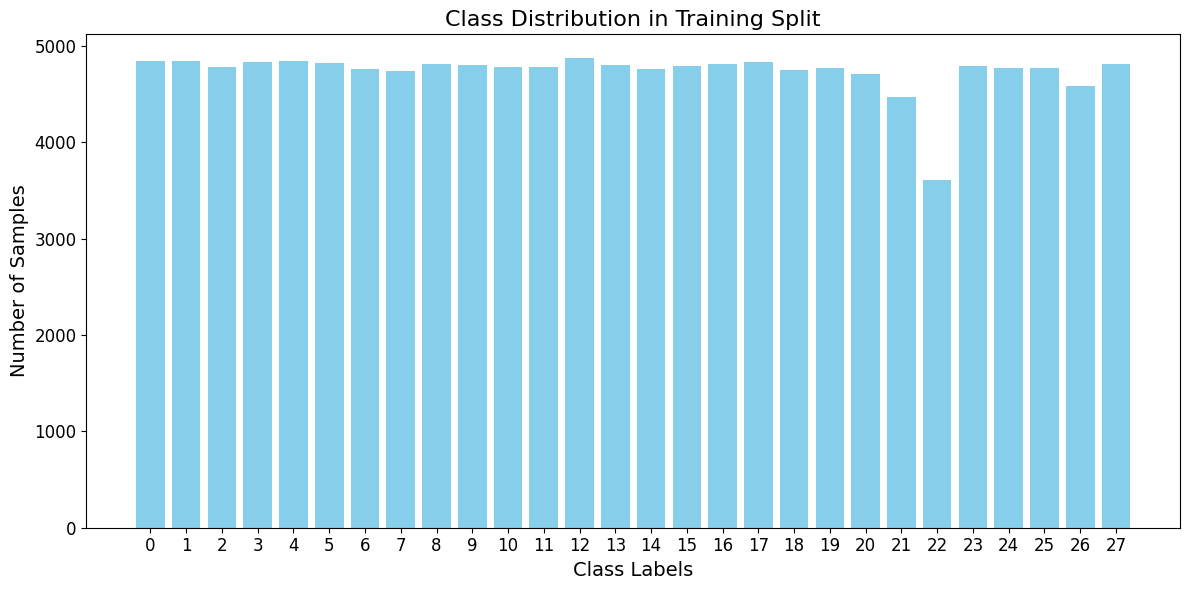

In [ ]:
plot_class_distribution(train_split, "Class Distribution in Training Split")

### Validation split

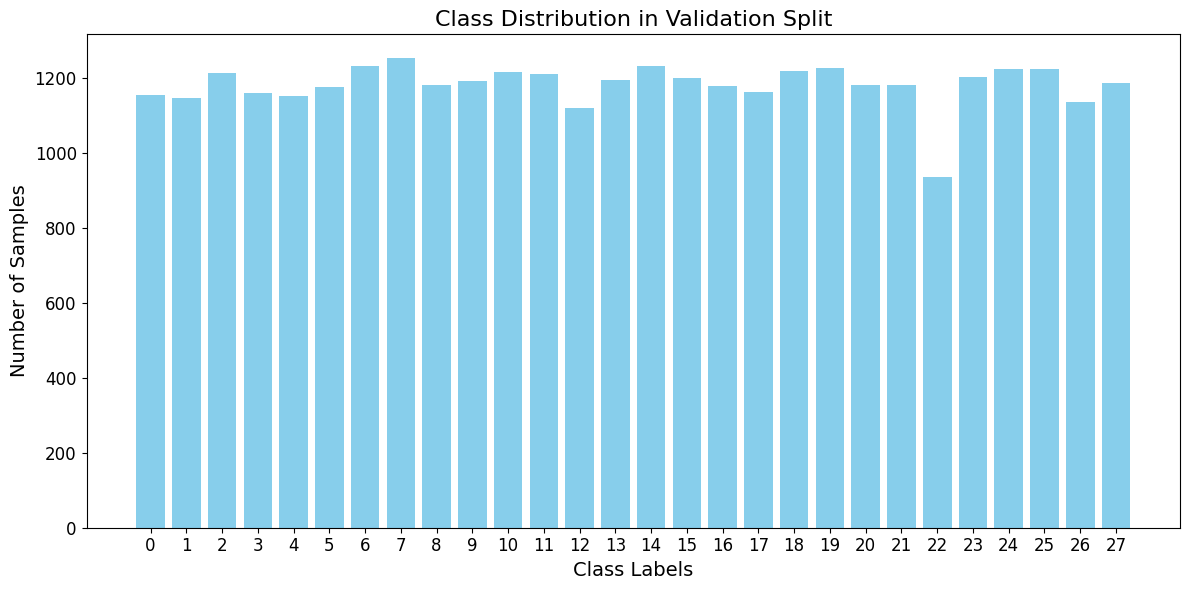

In [ ]:
# Plot for validation split
plot_class_distribution(val_split, "Class Distribution in Validation Split")

### Test split

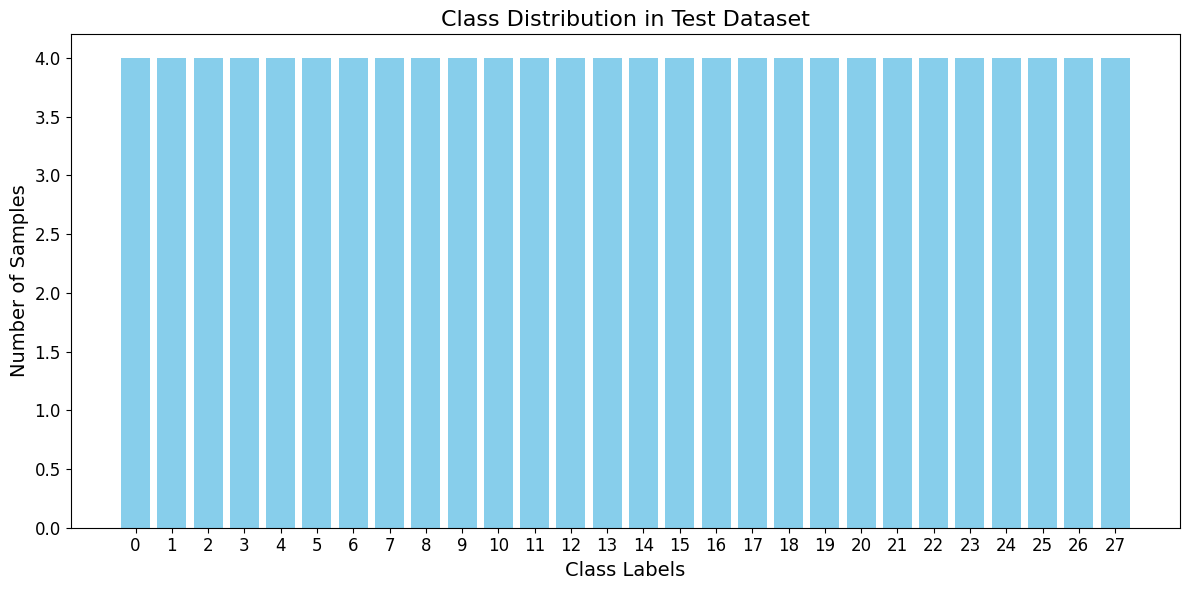

In [ ]:
# Plot for test dataset
plot_class_distribution(test_dataset, "Class Distribution in Test Dataset")

## Model Training - Full ViT Training

### Trainer Class

In [8]:
from tqdm import tqdm
import torch

class Trainer:
    def __init__(self, model, optimizer, loss_fn, device, scheduler=None):
        """
        Initialize the Trainer class.

        Args:
            model (torch.nn.Module): The model to train.
            optimizer (torch.optim.Optimizer): Optimizer for updating weights.
            loss_fn (torch.nn.Module): Loss function.
            device (torch.device): Device to run training (CPU/GPU).
            scheduler (torch.optim.lr_scheduler, optional): Learning rate scheduler. Default is None.
        """
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device
        self.scheduler = scheduler  # Optional scheduler

    def train_epoch(self, train_loader):
        """Train for one epoch and return loss and accuracy."""
        self.model.train()
        total_loss = 0
        correct = 0

        with tqdm(train_loader, desc="Training", unit="batch") as t:
            for images, labels in t:
                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                logits = self.model(images)
                loss = self.loss_fn(logits, labels)
                loss.backward()
                self.optimizer.step()

                # Track loss and correct predictions
                total_loss += loss.item() * len(images)
                predictions = torch.argmax(logits, dim=1)
                correct += (predictions == labels).sum().item()

                t.set_postfix(loss=loss.item())

        # Compute average loss and accuracy
        avg_loss = total_loss / len(train_loader.dataset)
        accuracy = correct / len(train_loader.dataset)
        return avg_loss, accuracy

    @torch.no_grad()
    def evaluate(self, dataloader):
        """Evaluate the model and return loss and accuracy."""
        self.model.eval()
        total_loss = 0
        correct = 0

        with tqdm(dataloader, desc="Validating", unit="batch") as t:
            for images, labels in t:
                images, labels = images.to(self.device), labels.to(self.device)
                logits = self.model(images)
                loss = self.loss_fn(logits, labels)

                # Track loss and correct predictions
                total_loss += loss.item() * len(images)
                predictions = torch.argmax(logits, dim=1)
                correct += (predictions == labels).sum().item()

        # Compute average loss and accuracy
        avg_loss = total_loss / len(dataloader.dataset)
        accuracy = correct / len(dataloader.dataset)
        return avg_loss, accuracy

    def get_current_lr(self):
        """Retrieve the current learning rate from the optimizer."""
        return self.optimizer.param_groups[0]['lr']

    def train(self, train_loader, val_loader, epochs):
        """Train the model and evaluate it after each epoch."""
        train_losses, train_accuracies = [], []
        val_losses, val_accuracies = [], []
        learning_rates = []  # Track learning rate for each epoch

        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs}")

            # Training phase
            train_loss, train_accuracy = self.train_epoch(train_loader)
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)

            # Validation phase
            val_loss, val_accuracy = self.evaluate(val_loader)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            # Get the learning rate
            current_lr = self.get_current_lr()
            learning_rates.append(current_lr)

            # Print epoch metrics
            print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
            print(f"Learning Rate: {current_lr:.6f}")

            # Step the scheduler, if provided
            if self.scheduler:
                self.scheduler.step(val_loss)  # Use validation loss for ReduceLROnPlateau

            torch.cuda.empty_cache()

        return train_losses, train_accuracies, val_losses, val_accuracies, learning_rates




## Confusion Matrix Plot

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()


## ViT Tiny Whole model Fine-tuning

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model
import time

# Load the pre-trained ViT-Tiny model from timm
model = create_model(
    "vit_tiny_patch16_224",  # Pre-trained ViT-Tiny on ImageNet-1k
    pretrained=True,         # Load pre-trained weights
    num_classes=num_classes  # Use dynamic number of classes
)



# Unfreeze the entire model (train all layers)
for param in model.parameters():
    param.requires_grad = True

# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=2e-4, weight_decay=1e-2
)

# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()


# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Train the full ViT model
trainer = Trainer(model, optimizer, loss_fn, device, scheduler=None)
start_time = time.time()

train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=1
)

# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")

Epoch 1/1


Validating: 100%|██████████| 518/518 [03:01<00:00,  2.85batch/s]

Train Loss: 0.0266, Train Accuracy: 0.9935
Validation Loss: 0.0035, Validation Accuracy: 0.9995
Learning Rate: 0.000200
Learning rates per epoch: [0.0002]
Training completed in: 2206.06 seconds


### ViT-Tiny Confusion Matrix Plot

In [ ]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time


# Generate predictions and true labels
y_true_classifier = []
y_pred_classifier = []
class_names = train_dataset.classes  # Automatically get class names from dataset

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Use the validation DataLoader
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true_classifier, y_pred_classifier)

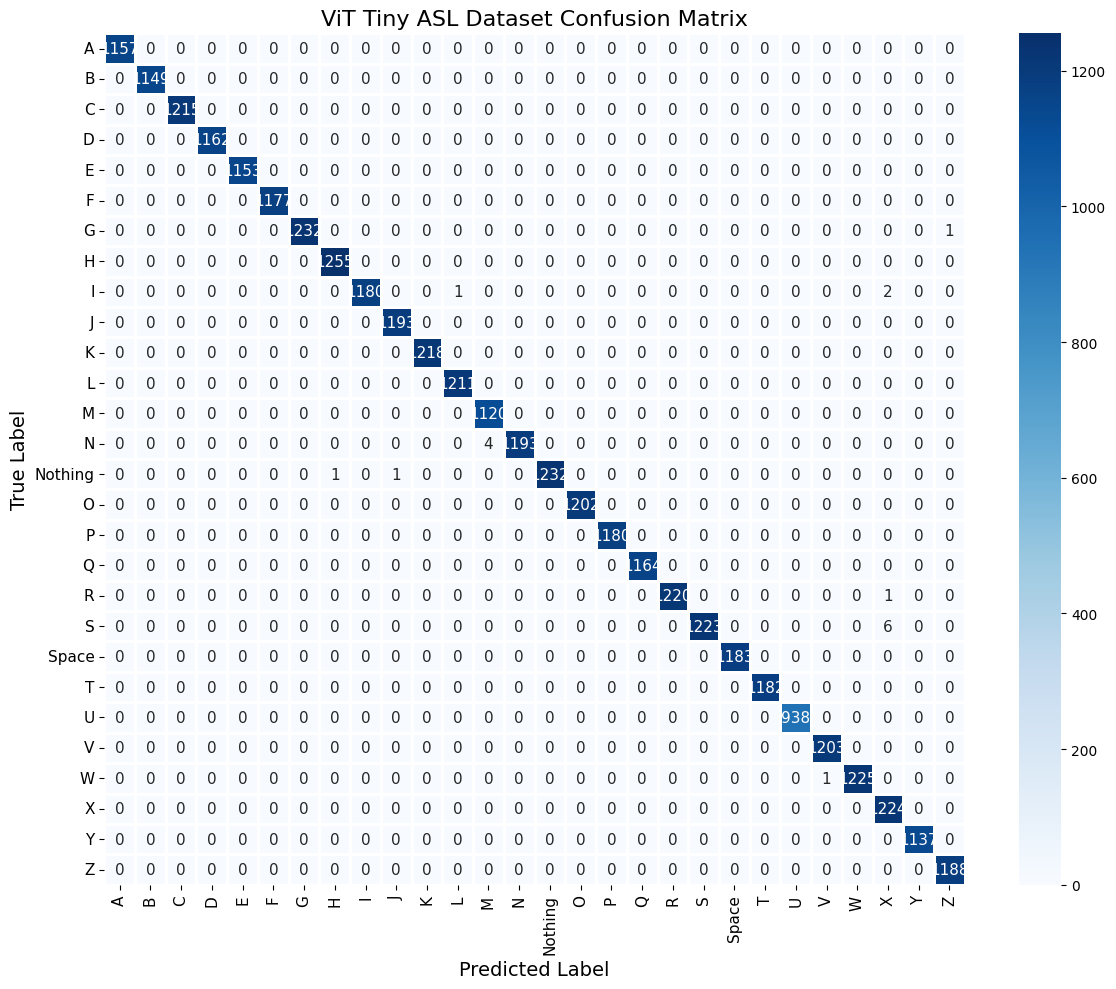

In [ ]:
# Plot the confusion matrix with a larger figure size and bigger margins
plt.figure(figsize=(12, 10))  # Adjust the figsize to make the plot larger
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True,
            annot_kws={"size": 11}, linewidths=1.8)  # Increase linewidth for better visibility of borders
plt.title("ViT Tiny ASL Dataset Confusion Matrix", fontsize=16)  # Increase font size of the title
plt.xlabel("Predicted Label", fontsize=14)  # Increase font size of the x-axis label
plt.ylabel("True Label", fontsize=14)  # Increase font size of the y-axis label
plt.xticks(fontsize=11)  # Set x-tick font size
plt.yticks(fontsize=11)

# Adjust the padding around the plot and labels
plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.15)  # Adjust the plot margins
plt.tight_layout()  # Ensure everything fits nicely within the plot area
plt.show()


### Calculate test accuracy

In [ ]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Validating: 100%|██████████| 2/2 [00:00<00:00,  3.21batch/s]

Test Loss: 0.0009, Test Accuracy: 1.0000


## ViT-Tiny Classifier Only Fine-Tuning

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model
import torch.optim as optim
import time

# Load the pre-trained ViT-Tiny model from timm
model = create_model(
    "vit_tiny_patch16_224",  # Pre-trained ViT-Tiny on ImageNet-1k
    pretrained=True,         # Load pre-trained weights
    num_classes=num_classes  # Use dynamic number of classes
)

# Freeze all layers except the classifier head
for param in model.parameters():
    param.requires_grad = False

# Only unfreeze the classifier head
for param in model.head.parameters():
    param.requires_grad = True


# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=1e-3, weight_decay=1e-2
)
# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()


# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Train only the classifier head
trainer = Trainer(model, optimizer, loss_fn, device)
start_time = time.time()

train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=3
)

# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")


Epoch 1/3


Validating: 100%|██████████| 518/518 [02:56<00:00,  2.93batch/s]


Train Loss: 0.0900, Train Accuracy: 0.9864
Validation Loss: 0.0139, Validation Accuracy: 0.9982
Learning Rate: 0.001000
Epoch 2/3


Validating: 100%|██████████| 518/518 [02:58<00:00,  2.90batch/s]


Train Loss: 0.0090, Train Accuracy: 0.9985
Validation Loss: 0.0081, Validation Accuracy: 0.9985
Learning Rate: 0.001000
Epoch 3/3


Validating: 100%|██████████| 518/518 [02:56<00:00,  2.93batch/s]

Train Loss: 0.0056, Train Accuracy: 0.9989
Validation Loss: 0.0054, Validation Accuracy: 0.9988
Learning Rate: 0.001000
Learning rates per epoch: [0.001, 0.001, 0.001]
Training completed in: 2682.80 seconds


### Validation - Training loss and accuracy plot

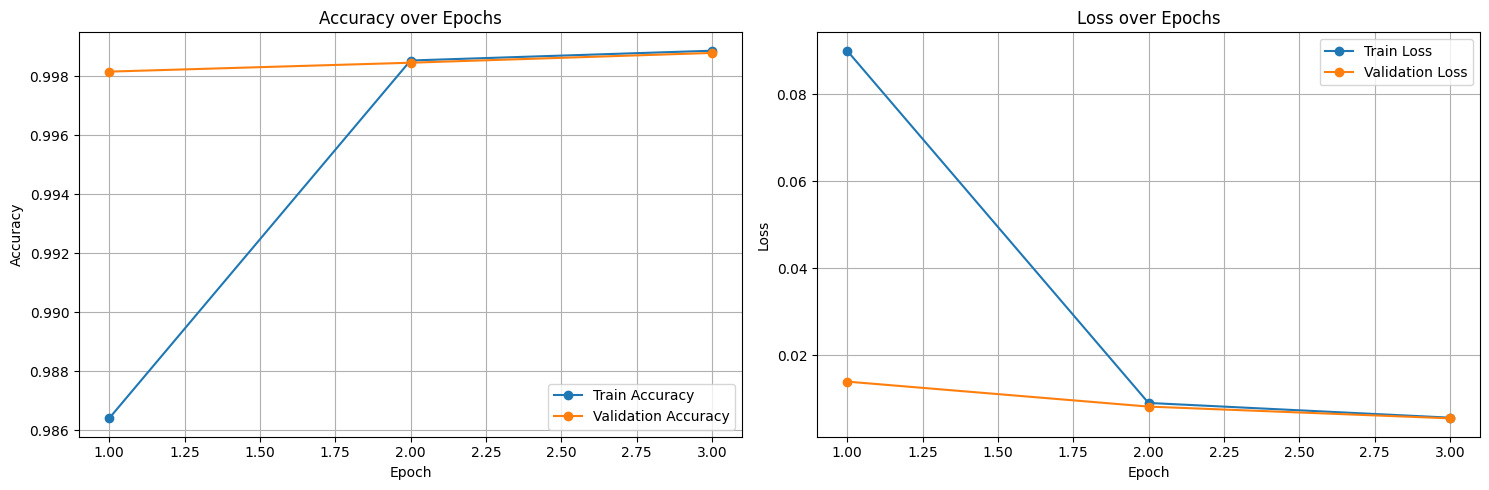

In [ ]:
import matplotlib.pyplot as plt

# Create subplots: one for accuracy and one for loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot train and validation accuracy
axes[0].plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label="Train Accuracy")
axes[0].plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label="Validation Accuracy")
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Train Loss")
axes[1].plot(range(1, len(val_losses) + 1), val_losses, marker='o', label="Validation Loss")
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


### ViT-Tiny Classifier Only Confusion Matrix Plot

In [ ]:
# Generate predictions and true labels
y_true_classifier = []
y_pred_classifier = []
class_names = train_dataset.classes  # Automatically get class names from dataset

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Use the validation DataLoader
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true_classifier, y_pred_classifier)


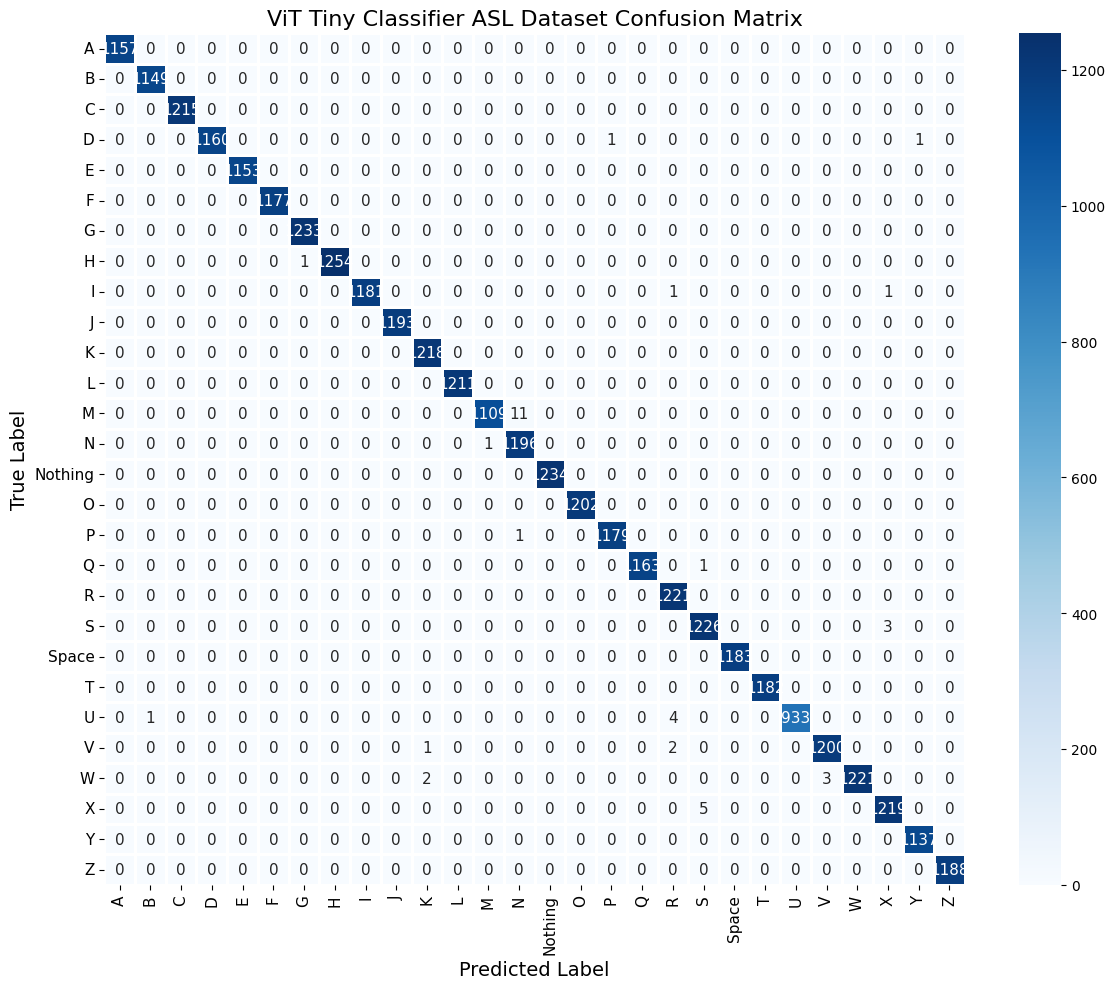

In [ ]:
# Plot the confusion matrix with a larger figure size and bigger margins
plt.figure(figsize=(12, 10))  # Adjust the figsize to make the plot larger
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True,
            annot_kws={"size": 11}, linewidths=1.8)  # Increase linewidth for better visibility of borders
plt.title("ViT Tiny Classifier ASL Dataset Confusion Matrix", fontsize=16)  # Increase font size of the title
plt.xlabel("Predicted Label", fontsize=14)  # Increase font size of the x-axis label
plt.ylabel("True Label", fontsize=14)  # Increase font size of the y-axis label
plt.xticks(fontsize=11)  # Set x-tick font size
plt.yticks(fontsize=11)

# Adjust the padding around the plot and labels
plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.15)  # Adjust the plot margins
plt.tight_layout()  # Ensure everything fits nicely within the plot area
plt.show()

### Calculate test accuracy

In [ ]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)


Validating: 100%|██████████| 2/2 [00:00<00:00,  2.66batch/s]


In [ ]:
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.0022, Test Accuracy: 1.0000


## ViT-Base Classifier Head Fine-tuning

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model
import torch.optim as optim
import time

# Load the pre-trained ViT-Tiny model from timm
model = create_model(
    "vit_base_patch16_224",  # Pre-trained ViT-Tiny on ImageNet-1k
    pretrained=True,         # Load pre-trained weights
    num_classes=num_classes  # Use dynamic number of classes
)

# Freeze all layers except the classifier head
for param in model.parameters():
    param.requires_grad = False

# Only unfreeze the classifier head
for param in model.head.parameters():
    param.requires_grad = True


# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=5e-4, weight_decay=1e-2
)
# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()


# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Train only the classifier head
trainer = Trainer(model, optimizer, loss_fn, device)
start_time = time.time()

train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=2
)

# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/2


Validating: 100%|██████████| 518/518 [08:06<00:00,  1.06batch/s]


Train Loss: 0.0774, Train Accuracy: 0.9904
Validation Loss: 0.0054, Validation Accuracy: 0.9999
Learning Rate: 0.000500
Epoch 2/2


Validating: 100%|██████████| 518/518 [08:06<00:00,  1.06batch/s]

Train Loss: 0.0027, Train Accuracy: 1.0000
Validation Loss: 0.0014, Validation Accuracy: 1.0000
Learning Rate: 0.000500
Learning rates per epoch: [0.0005, 0.0005]
Training completed in: 4879.57 seconds


### ViT-Base Confusion Matrix Plot

In [ ]:
# Generate predictions and true labels
y_true_classifier = []
y_pred_classifier = []
class_names = train_dataset.classes  # Automatically get class names from dataset

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Use the validation DataLoader
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true_classifier, y_pred_classifier)

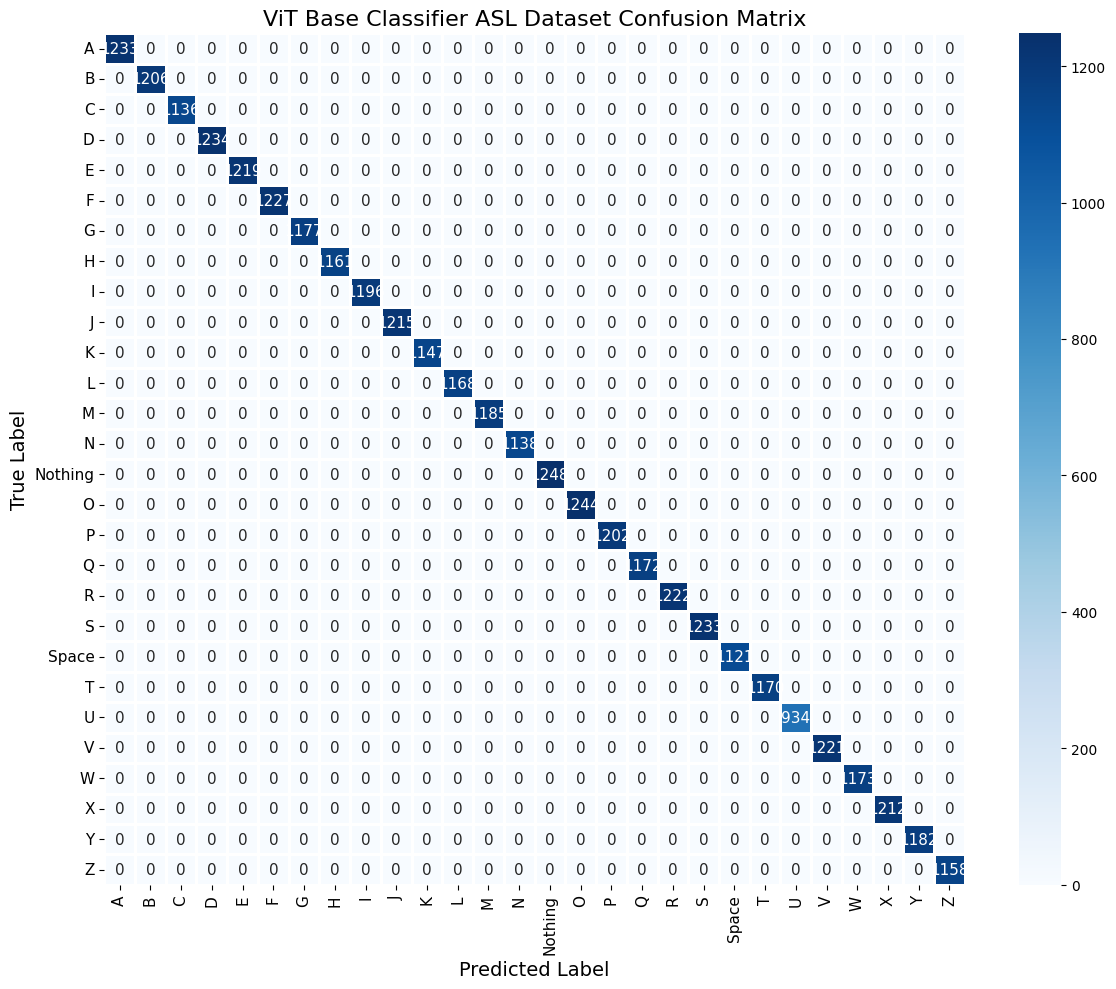

In [ ]:
# Plot the confusion matrix with a larger figure size and bigger margins
plt.figure(figsize=(12, 10))  # Adjust the figsize to make the plot larger
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True,
            annot_kws={"size": 11}, linewidths=1.8)  # Increase linewidth for better visibility of borders
plt.title("ViT Base Classifier ASL Dataset Confusion Matrix", fontsize=16)  # Increase font size of the title
plt.xlabel("Predicted Label", fontsize=14)  # Increase font size of the x-axis label
plt.ylabel("True Label", fontsize=14)  # Increase font size of the y-axis label
plt.xticks(fontsize=11)  # Set x-tick font size
plt.yticks(fontsize=11)

# Adjust the padding around the plot and labels
plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.15)  # Adjust the plot margins
plt.tight_layout()  # Ensure everything fits nicely within the plot area
plt.show()

### Calculate Test Accuracy

In [ ]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Validating: 100%|██████████| 2/2 [00:01<00:00,  1.30batch/s]

Test Loss: 0.0005, Test Accuracy: 1.0000


### Validation - Training loss and accuracy plot

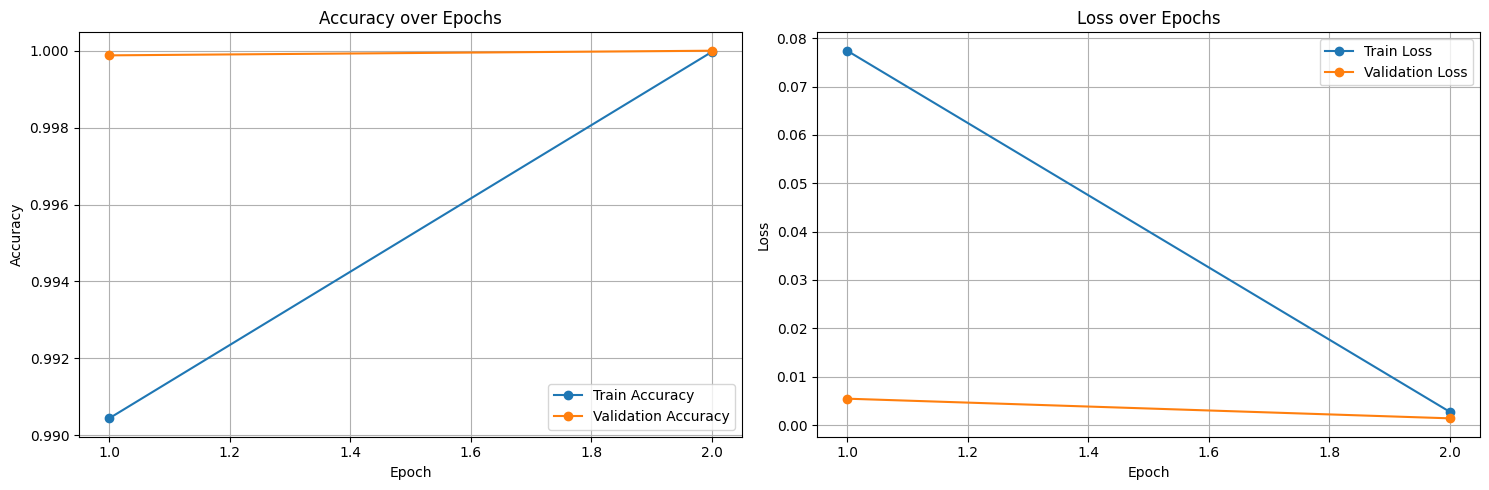

In [ ]:
import matplotlib.pyplot as plt

# Create subplots: one for accuracy and one for loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot train and validation accuracy
axes[0].plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label="Train Accuracy")
axes[0].plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label="Validation Accuracy")
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Train Loss")
axes[1].plot(range(1, len(val_losses) + 1), val_losses, marker='o', label="Validation Loss")
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

## EfficientViT-M5 Tiny Fine-Tuning

In [10]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model
import time
# Load the pre-trained ViT-Tiny model from timm
model = create_model(
    "efficientvit_m5.r224_in1k",  # Pre-trained ViT-Tiny on ImageNet-1k
    pretrained=True,         # Load pre-trained weights
    num_classes=num_classes  # Use dynamic number of classes
)


# Unfreeze the entire model (train all layers)
for param in model.parameters():
    param.requires_grad = True

# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=2e-4, weight_decay=1e-2
)

# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()


# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Train the full ViT model
trainer = Trainer(model, optimizer, loss_fn, device, scheduler=None)

start_time = time.time()

train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=2
)

# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/50.3M [00:00<?, ?B/s]

Epoch 1/2


Validating: 100%|██████████| 518/518 [03:10<00:00,  2.72batch/s]


Train Loss: 0.1681, Train Accuracy: 0.9854
Validation Loss: 0.0023, Validation Accuracy: 0.9999
Learning Rate: 0.000200
Epoch 2/2


Validating: 100%|██████████| 518/518 [03:02<00:00,  2.83batch/s]

Train Loss: 0.0047, Train Accuracy: 0.9991
Validation Loss: 0.0006, Validation Accuracy: 1.0000
Learning Rate: 0.000200
Learning rates per epoch: [0.0002, 0.0002]
Training completed in: 2323.62 seconds


### Validation - Training loss and accuracy plot

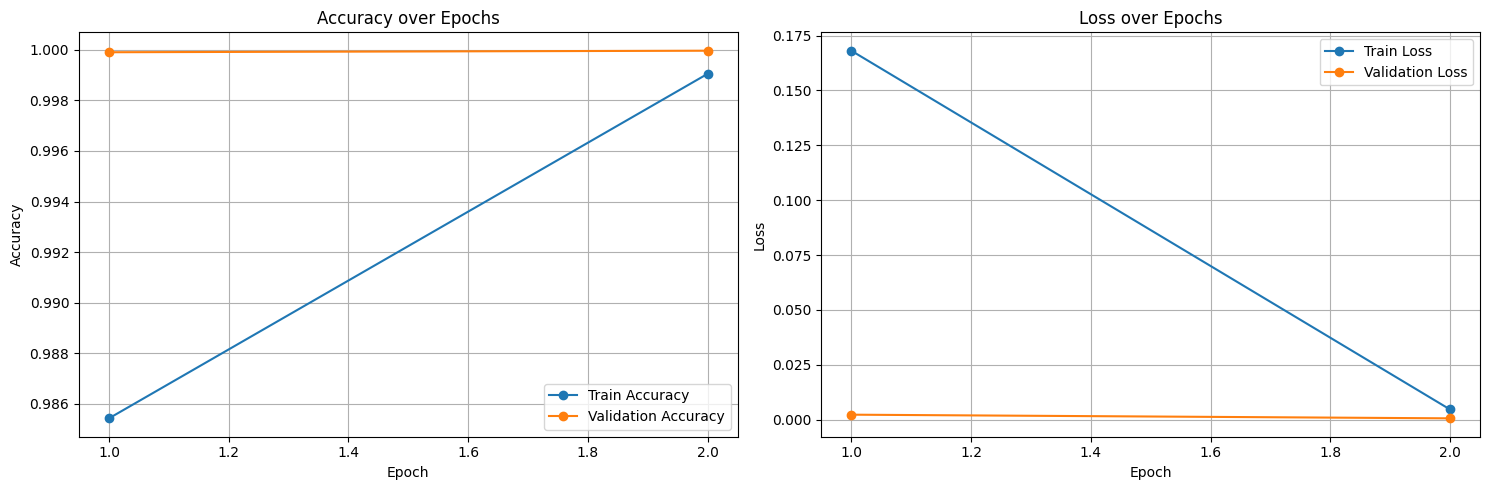

In [11]:
import matplotlib.pyplot as plt

# Create subplots: one for accuracy and one for loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot train and validation accuracy
axes[0].plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label="Train Accuracy")
axes[0].plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label="Validation Accuracy")
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Train Loss")
axes[1].plot(range(1, len(val_losses) + 1), val_losses, marker='o', label="Validation Loss")
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

### Confusion Matrix Plot


In [12]:
# Generate predictions and true labels
y_true_classifier = []
y_pred_classifier = []
class_names = train_dataset.classes  # Automatically get class names from dataset

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Use the validation DataLoader
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true_classifier, y_pred_classifier)

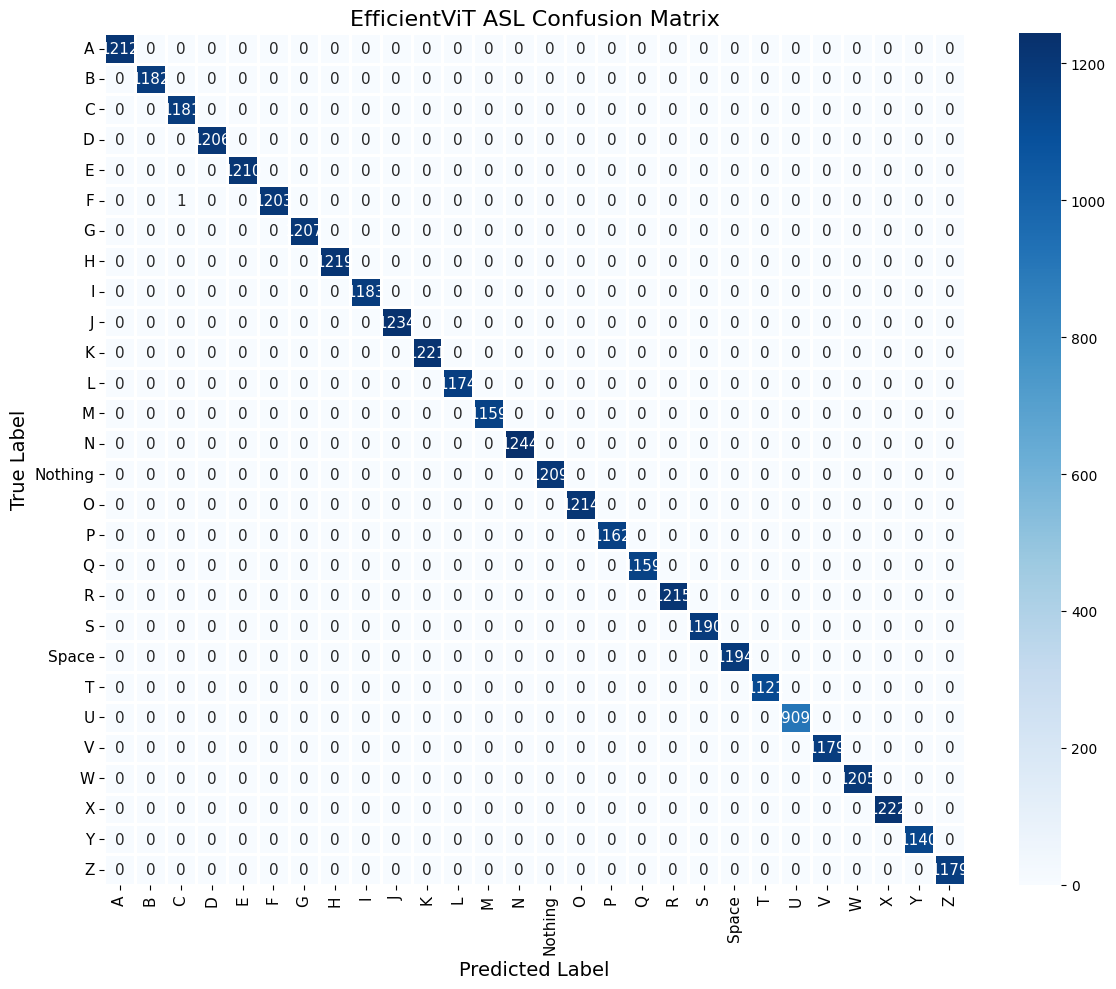

In [13]:
# Plot the confusion matrix with a larger figure size and bigger margins
plt.figure(figsize=(12, 10))  # Adjust the figsize to make the plot larger
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True,
            annot_kws={"size": 11}, linewidths=1.8)  # Increase linewidth for better visibility of borders
plt.title("EfficientViT ASL Confusion Matrix", fontsize=16)  # Increase font size of the title
plt.xlabel("Predicted Label", fontsize=14)  # Increase font size of the x-axis label
plt.ylabel("True Label", fontsize=14)  # Increase font size of the y-axis label
plt.xticks(fontsize=11)  # Set x-tick font size
plt.yticks(fontsize=11)

# Adjust the padding around the plot and labels
plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.15)  # Adjust the plot margins
plt.tight_layout()  # Ensure everything fits nicely within the plot area
plt.show()

In [14]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Validating: 100%|██████████| 2/2 [00:00<00:00,  2.58batch/s]

Test Loss: 0.0005, Test Accuracy: 1.0000


## DeIT-III Small Fine-tuning

In [15]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model
import time
# Load the pre-trained ViT-Tiny model from timm
model = create_model(
    "deit3_small_patch16_224.fb_in22k_ft_in1k",  # Pre-trained ViT-Tiny on ImageNet-1k
    pretrained=True,         # Load pre-trained weights
    num_classes=num_classes  # Use dynamic number of classes
)


# Unfreeze the entire model (train all layers)
for param in model.parameters():
    param.requires_grad = True

# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=2e-4, weight_decay=1e-2
)

# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()


# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Train the full ViT model
trainer = Trainer(model, optimizer, loss_fn, device, scheduler=None)

start_time = time.time()

train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=1
)

# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")

model.safetensors:   0%|          | 0.00/88.3M [00:00<?, ?B/s]

Epoch 1/1


Validating: 100%|██████████| 518/518 [03:50<00:00,  2.25batch/s]

Train Loss: 0.0234, Train Accuracy: 0.9940
Validation Loss: 0.0001, Validation Accuracy: 1.0000
Learning Rate: 0.000200
Learning rates per epoch: [0.0002]
Training completed in: 2056.61 seconds


### Confusion Matrix Plot


In [16]:
# Generate predictions and true labels
y_true_classifier = []
y_pred_classifier = []
class_names = train_dataset.classes  # Automatically get class names from dataset

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Use the validation DataLoader
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true_classifier, y_pred_classifier)

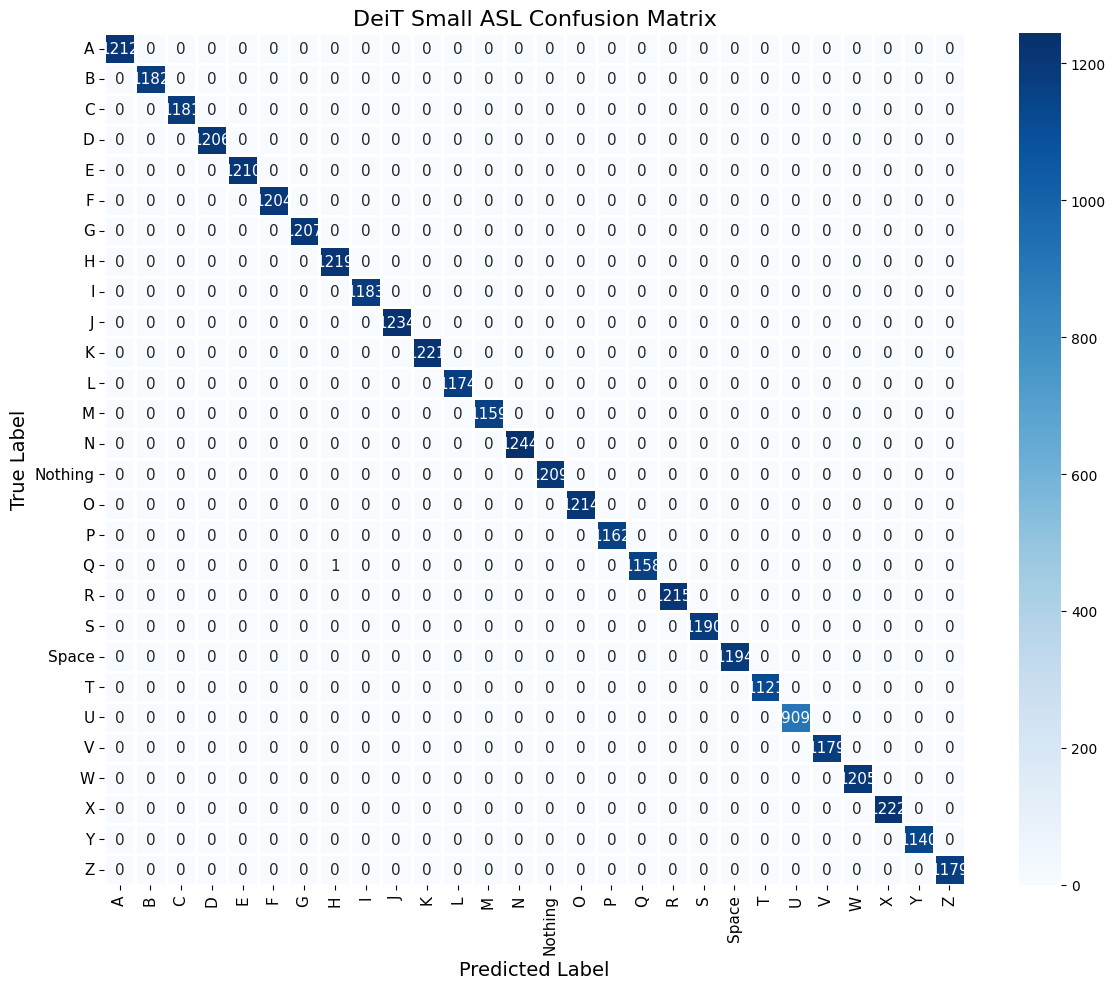

In [17]:
# Plot the confusion matrix with a larger figure size and bigger margins
plt.figure(figsize=(12, 10))  # Adjust the figsize to make the plot larger
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True,
            annot_kws={"size": 11}, linewidths=1.8)  # Increase linewidth for better visibility of borders
plt.title("DeiT Small ASL Confusion Matrix", fontsize=16)  # Increase font size of the title
plt.xlabel("Predicted Label", fontsize=14)  # Increase font size of the x-axis label
plt.ylabel("True Label", fontsize=14)  # Increase font size of the y-axis label
plt.xticks(fontsize=11)  # Set x-tick font size
plt.yticks(fontsize=11)

# Adjust the padding around the plot and labels
plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.15)  # Adjust the plot margins
plt.tight_layout()  # Ensure everything fits nicely within the plot area
plt.show()

### Validation - Training loss and accuracy plot

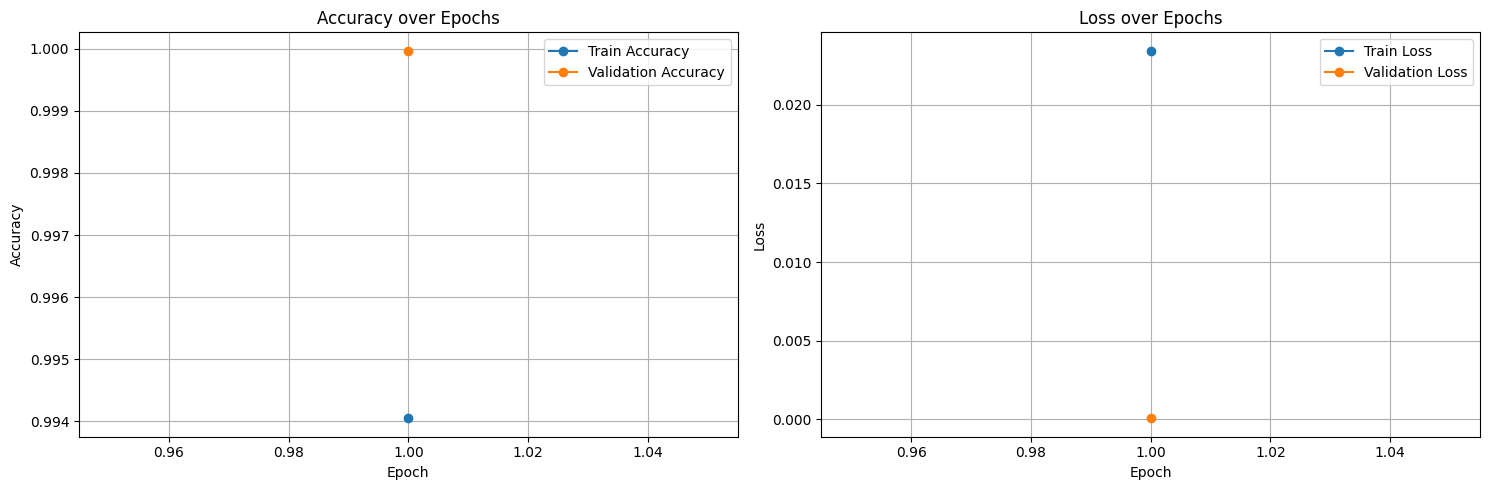

In [18]:
import matplotlib.pyplot as plt

# Create subplots: one for accuracy and one for loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot train and validation accuracy
axes[0].plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label="Train Accuracy")
axes[0].plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label="Validation Accuracy")
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Train Loss")
axes[1].plot(range(1, len(val_losses) + 1), val_losses, marker='o', label="Validation Loss")
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

### Calculate test accuracy


In [19]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Validating: 100%|██████████| 2/2 [00:00<00:00,  2.31batch/s]

Test Loss: 0.0000, Test Accuracy: 1.0000
